<br/>

# Coming up with the best features

Dr Li suggested that I find the top 5 feature-sets recommended to predict DoA using EEG using a linear regression model. However, I tried other models for exploratory purposes.

<br/>

In [8]:
## Potential features
test_features_A = ['SampenCD_2D', 'Katz_cD_1DS', 'Petrosian_CD_3']
test_features_B = ['SampenCD_2D', 'Petrosian_CD_3D', 'Petrosian_CD_1DS']

<br/>

## Training performance: <code>Support Vector Regression</code>

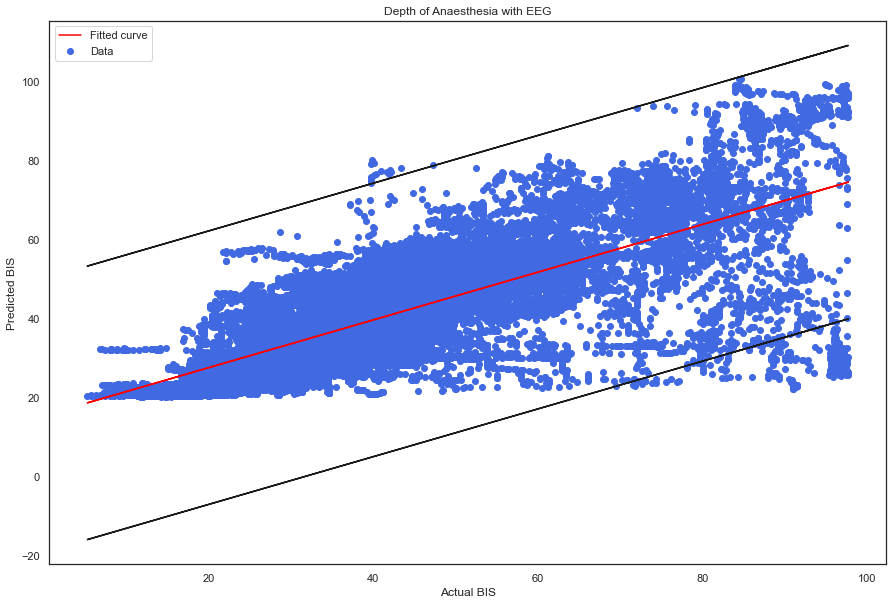

Metrics(r2=0.559260042444752, mse=160.49568118949867)

<br/>

<br/>

# TESTING

## Testing Model: <code>Support Vector Regression</code>

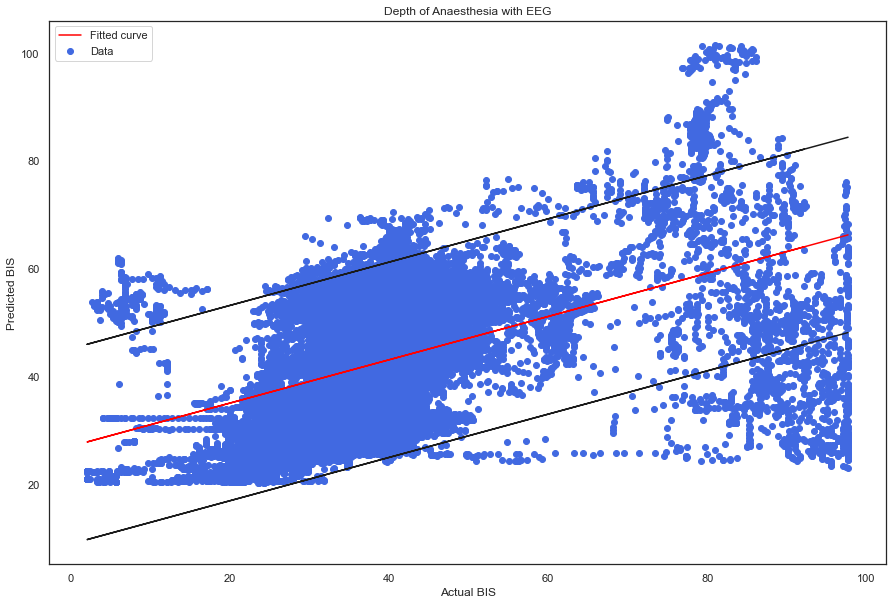

Metrics(r2=0.04942670000208471, mse=214.72352048192818)

In [11]:
# Using the testing data
svr.predict(test_df, test_features_A, visualize_scatter=True, save=True)

<br/>

<br/>

# DoA prediction in test patients

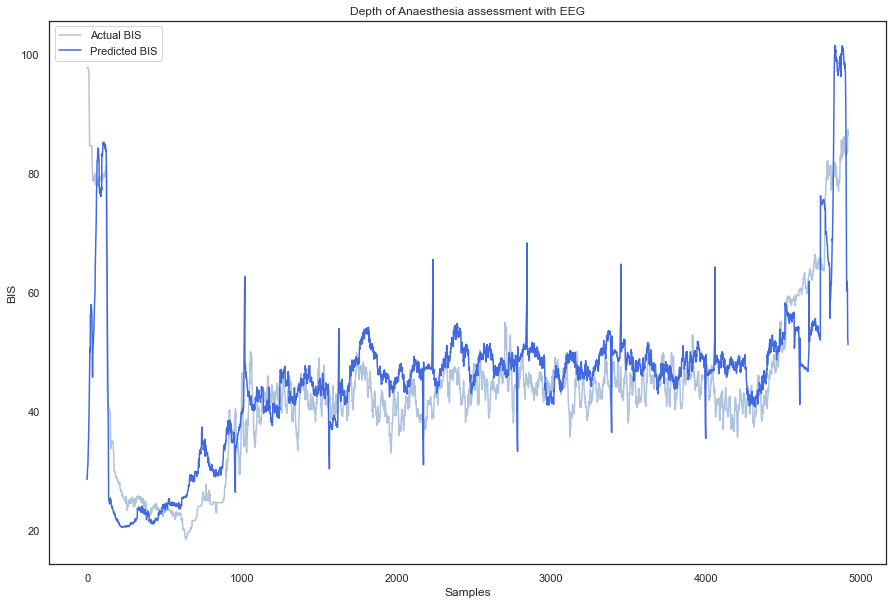

Metrics(r2=0.651478204768527, mse=57.81962893111251)


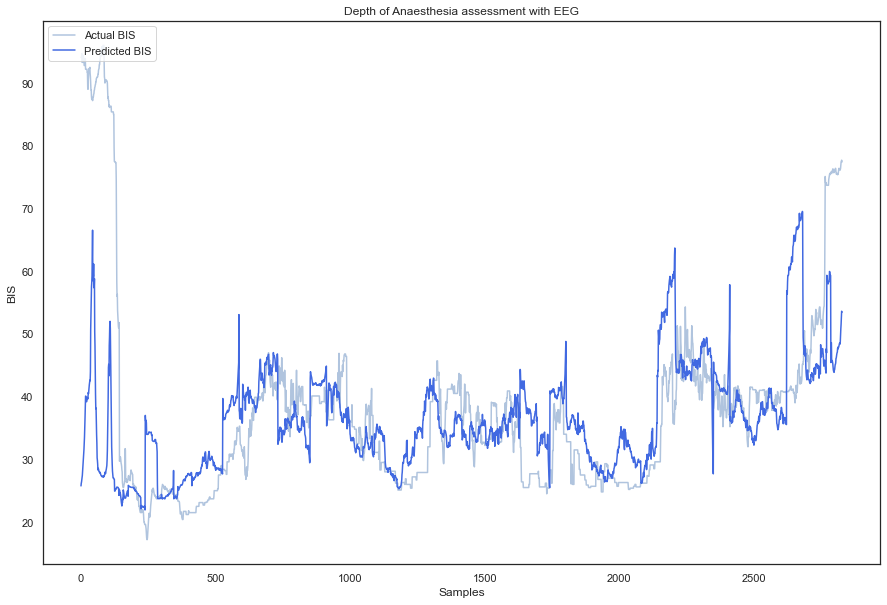

Metrics(r2=0.11012695135011374, mse=203.49184777726313)


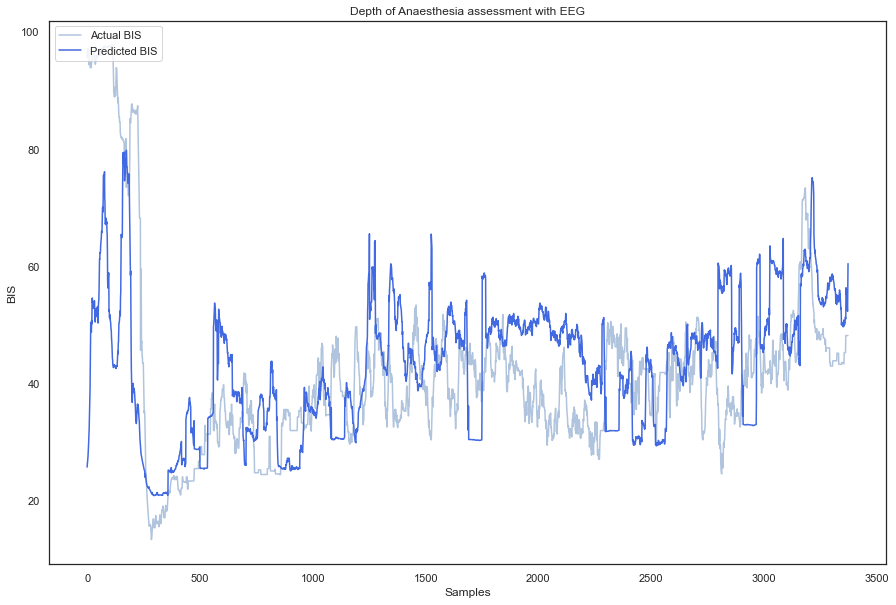

Metrics(r2=0.11273237940133696, mse=220.8410916546244)


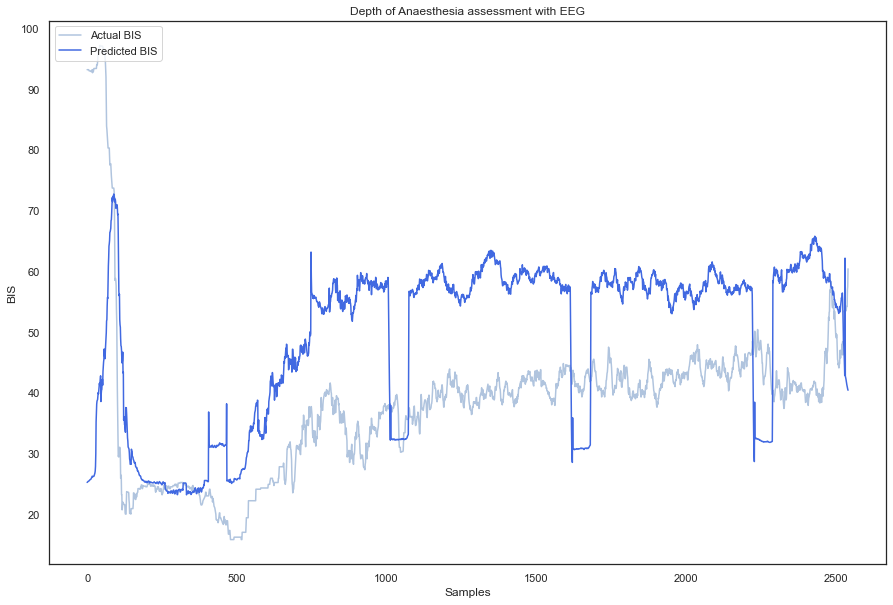

Metrics(r2=-0.9513550029241238, mse=338.18585573612756)


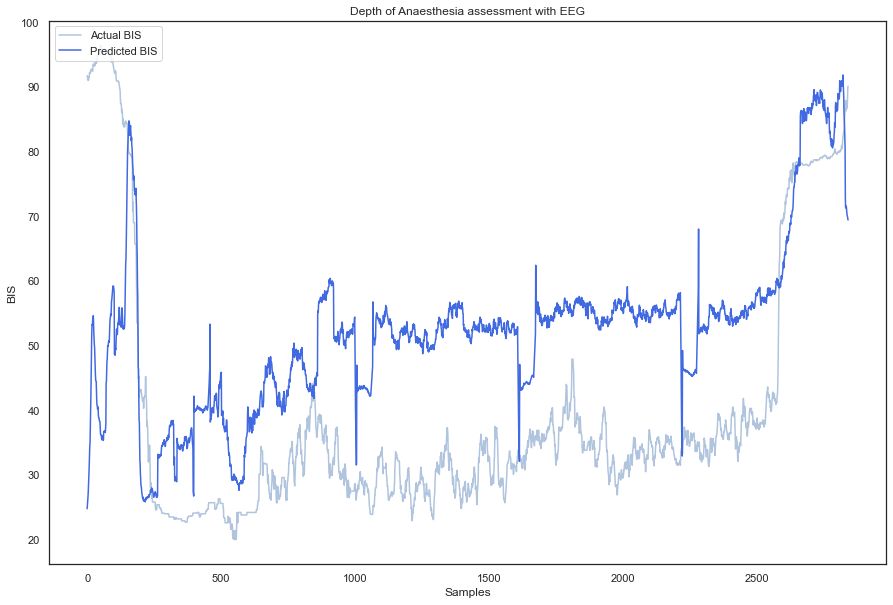

Metrics(r2=-0.10346093213931895, mse=414.51016897053444)


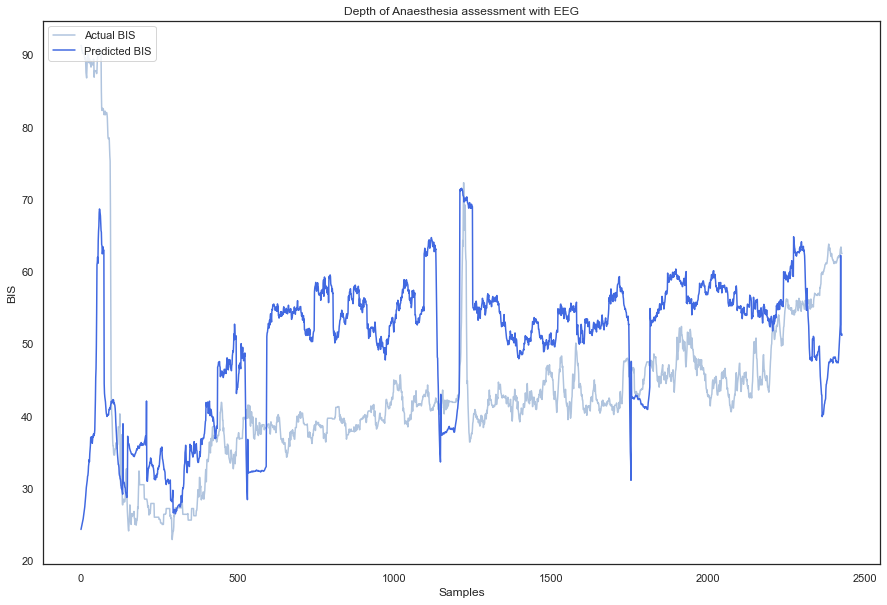

Metrics(r2=-0.5769092207283832, mse=212.9028759198766)


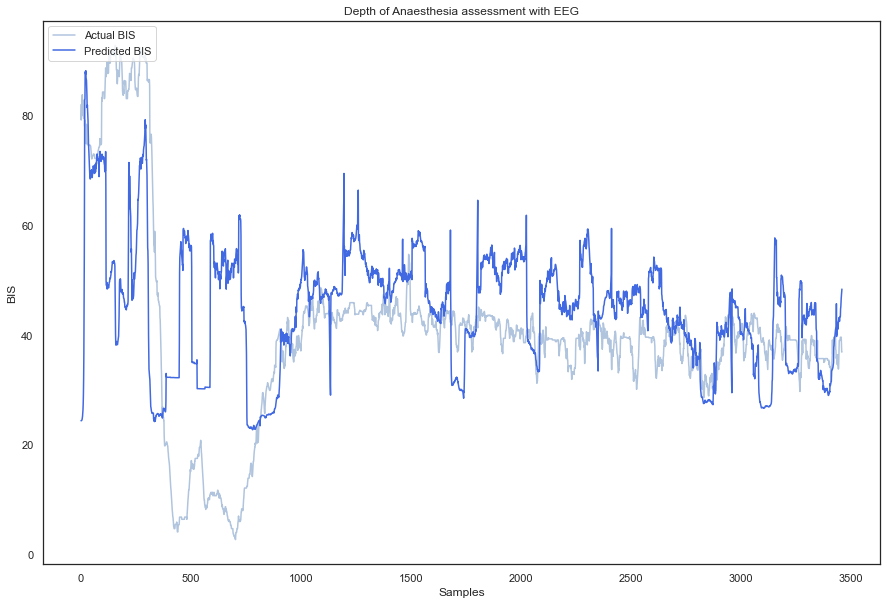

Metrics(r2=-0.0026955968024948707, mse=307.4320469427432)


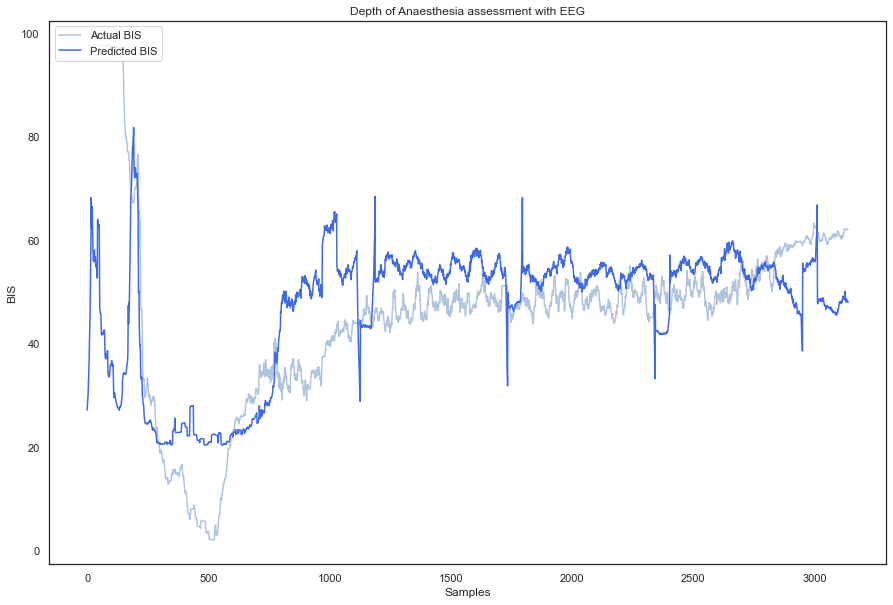

Metrics(r2=0.21084315769301787, mse=257.3172675658125)


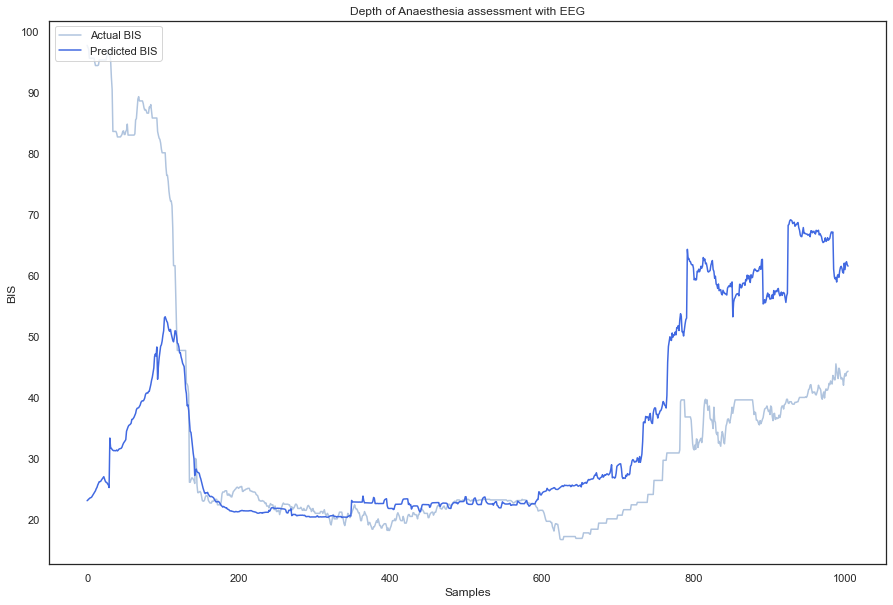

Metrics(r2=-0.050005606616555065, mse=452.2892318460171)


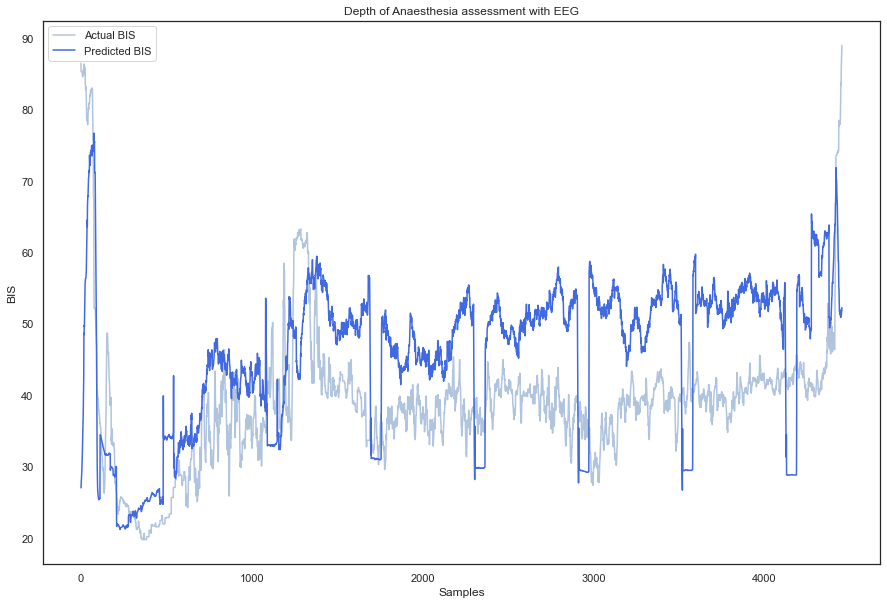

Metrics(r2=-0.597026240956857, mse=148.29427981333217)


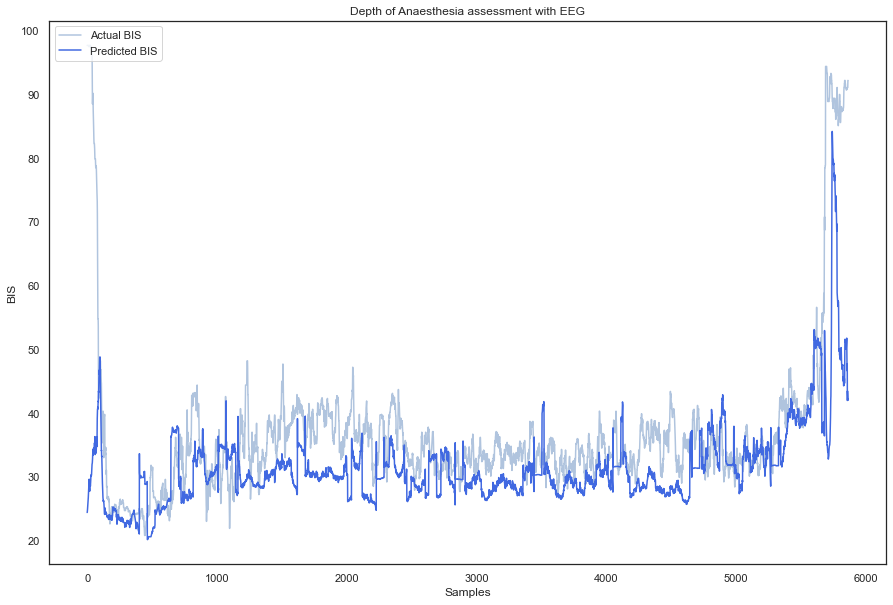

Metrics(r2=0.15883520000964302, mse=130.91936711683243)


<br/>